In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import (
    mean_absolute_error, r2_score, mean_squared_error,
    accuracy_score, classification_report
)
import joblib

# 2. Load Dataset
df = pd.read_csv("zameen_homes_data_v1.csv")

# 3. Clean and Convert Price Column
def convert_price(price_str):
    try:
        price_str = price_str.replace("PKR", "").replace(",", "").strip().lower()
        if "crore" in price_str:
            return float(price_str.replace("crore", "").strip()) * 1e7
        elif "million" in price_str:
            return float(price_str.replace("million", "").strip()) * 1e6
        elif "lakh" in price_str:
            return float(price_str.replace("lakh", "").strip()) * 1e5
        else:
            return float(price_str)
    except:
        return np.nan

df['price'] = df['price'].apply(convert_price)

# 4. Convert Area to Marla
def convert_area(area_str):
    try:
        area_str = area_str.lower().strip()
        value, unit = area_str.split()
        value = float(value)
        if "marla" in unit:
            return value
        elif "kanal" in unit:
            return value * 20
        elif "square feet" in unit:
            return value / 225
        else:
            return np.nan
    except:
        return np.nan

df['area_marla'] = df['area'].apply(convert_area)

# 5. Convert Bedrooms and Bathrooms
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

# 6. Encode Neighborhood
df['neighborhood'] = df['location'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else np.nan)
df['neighborhood'] = df['neighborhood'].astype('category')
df['neighborhood_code'] = df['neighborhood'].cat.codes #Converts neighborhood names into numerical codes (e.g., "G-6" into 0, "F-10" into 1

# 7. Handle Extra Features (keep 'floors' only for display, not modeling)
extra_features = ['floors', 'parking_spaces', 'furnished']
df[extra_features] = df[extra_features].fillna(0)

# 8. Build Final Modeling Dataset (EXCLUDING 'floors')
model_features = ['area_marla', 'bedrooms', 'bathrooms', 'neighborhood_code', 'parking_spaces', 'furnished']
df_model = df[model_features + ['price']].dropna()

# 9. Define Features and Target
X = df_model.drop('price', axis=1)
y = df_model['price']

# 10. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 12. Train Final Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 13. Evaluate Random Forest
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    accuracy = 100 - mape

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:,.0f} PKR")
    print(f"RMSE: {rmse:,.0f} PKR")
    print(f"Estimated Accuracy: {accuracy:.2f}%")


evaluate_model("Random Forest", rf_model)

# 14. Save the Random Forest Model
joblib.dump(rf_model, "random_forest_house_price_model.pkl")

# 15. Naive Bayes with 5 Price Categories

category_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
price_bins = pd.qcut(y, q=5, labels=category_labels)
y_class = price_bins

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y_class, test_size=0.2, random_state=42)

lr_model = LinearRegression() #----------------
lr_model.fit(X_train_nb, pd.factorize(y_train_nb)[0])
y_pred_nb = lr_model.predict(X_test_nb)

print("\n Linear Regression Classification Performance (5 Price Categories):")
print(f"Accuracy: {accuracy_score(y_test_nb, y_pred_labels):.2f}")


# 16. Example Prediction Using Random Forest (WITHOUT 'floors')
print("\n Example House Price Prediction:")
neighborhood_input = "F-7"
area = 23
bedrooms = 6
bathrooms = 6
parking_spaces = 1
furnished = 0

if neighborhood_input in df['neighborhood'].cat.categories:
    neighborhood_code = df['neighborhood'].cat.categories.get_loc(neighborhood_input)
    if area <= 0 or bedrooms < 0 or bathrooms < 0:
        print("Invalid input values. Please check area, bedrooms, or bathrooms.")
    else:
        example = pd.DataFrame([{
            "area_marla": area,
            "bedrooms": bedrooms,
            "bathrooms": bathrooms,
            "neighborhood_code": neighborhood_code,
            "parking_spaces": parking_spaces,
            "furnished": furnished
        }])
        predicted_price = rf_model.predict(example)[0]
        print(f"Predicted Price for {area} Marla, {bedrooms} Bed, {bathrooms} Bath in {neighborhood_input} = PKR {predicted_price:,.0f}")
else:
    print(f"Neighborhood '{neighborhood_input}' not found in dataset.")



Random Forest Performance:
MAE: 12,455,444 PKR
RMSE: 31,391,788 PKR
Estimated Accuracy: 80.68%

 Naive Bayes Classification Performance (5 Price Categories):
Accuracy: 0.45

 Example House Price Prediction:
Predicted Price for 23 Marla, 6 Bed, 6 Bath in F-7 = PKR 317,541,667


In [5]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib

# 2. Load Your Dataset
df = pd.read_csv("zameen_homes_data_v1.csv")

# 3. Clean and Convert Price Column
def convert_price(price_str):
    try:
        price_str = price_str.replace("PKR", "").replace(",", "").strip().lower()
        if "crore" in price_str:
            return float(price_str.replace("crore", "").strip()) * 1e7
        elif "million" in price_str:
            return float(price_str.replace("million", "").strip()) * 1e6
        elif "lakh" in price_str:
            return float(price_str.replace("lakh", "").strip()) * 1e5
        else:
            return float(price_str)
    except:
        return np.nan

df['price'] = df['price'].apply(convert_price)

# 4. Convert Area to Marla
def convert_area(area_str):
    try:
        area_str = area_str.lower().strip()
        value, unit = area_str.split()
        value = float(value)
        if "marla" in unit:
            return value
        elif "kanal" in unit:
            return value * 20
        elif "square feet" in unit:
            return value / 225
        else:
            return np.nan
    except:
        return np.nan

df['area_marla'] = df['area'].apply(convert_area)

# 5. Convert Bedrooms and Bathrooms
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

# 6. Extract Neighborhood
df['neighborhood'] = df['location'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else np.nan)
df['neighborhood'] = df['neighborhood'].astype('category')
df['neighborhood_code'] = df['neighborhood'].cat.codes

# 7. Select Useful Extra Features
extra_features = ['floors', 'parking_spaces', 'furnished']
df[extra_features] = df[extra_features].fillna(0)

# 8. Build the Final Modeling Dataset (EXCLUDING 'floors')
columns = ['area_marla', 'bedrooms', 'bathrooms', 'neighborhood_code', 'parking_spaces', 'furnished', 'price']
df_model = df[columns].dropna()

# 9. Define Features and Target
X = df_model.drop('price', axis=1)
y = df_model['price']

# 10. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 11. Train Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# 12. Evaluation Function
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    accuracy = 100 - mape

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:,.0f} PKR")
    print(f"RMSE: {rmse:,.0f} PKR")
    print(f"Accuracy (estimated): {accuracy:.2f}%")

# 13. Evaluate Model
evaluate_model("Decision Tree", dt_model)

# 14. Save the Model
joblib.dump(dt_model, "decision_tree_house_price_model.pkl")

# 15. Example Prediction (EXCLUDING 'floors')
neighborhood_input = "F-7"
area = 23
bedrooms = 6
bathrooms = 6
parking_spaces = 1
furnished = 0

if neighborhood_input in df['neighborhood'].cat.categories:
    neighborhood_code = df['neighborhood'].cat.categories.get_loc(neighborhood_input)

    if area <= 0 or bedrooms < 0 or bathrooms < 0:
        print("\nInvalid input values. Please check area, bedrooms, or bathrooms.")
    else:
        example = pd.DataFrame([{
            "area_marla": area,
            "bedrooms": bedrooms,
            "bathrooms": bathrooms,
            "neighborhood_code": neighborhood_code,
            "parking_spaces": parking_spaces,
            "furnished": furnished
        }])

        predicted_price = dt_model.predict(example)[0]
        print(f"\nDecision Tree Prediction:")
        print(f"Predicted Price for {area} Marla, {bedrooms} Bed, {bathrooms} Bath in {neighborhood_input} = PKR {predicted_price:,.0f}")
else:
    print(f"\nNeighborhood '{neighborhood_input}' not found in dataset.")



Decision Tree Performance:
MAE: 12,849,298 PKR
RMSE: 34,368,256 PKR
Accuracy (estimated): 79.88%

Decision Tree Prediction:
Predicted Price for 23 Marla, 6 Bed, 6 Bath in F-7 = PKR 305,000,000


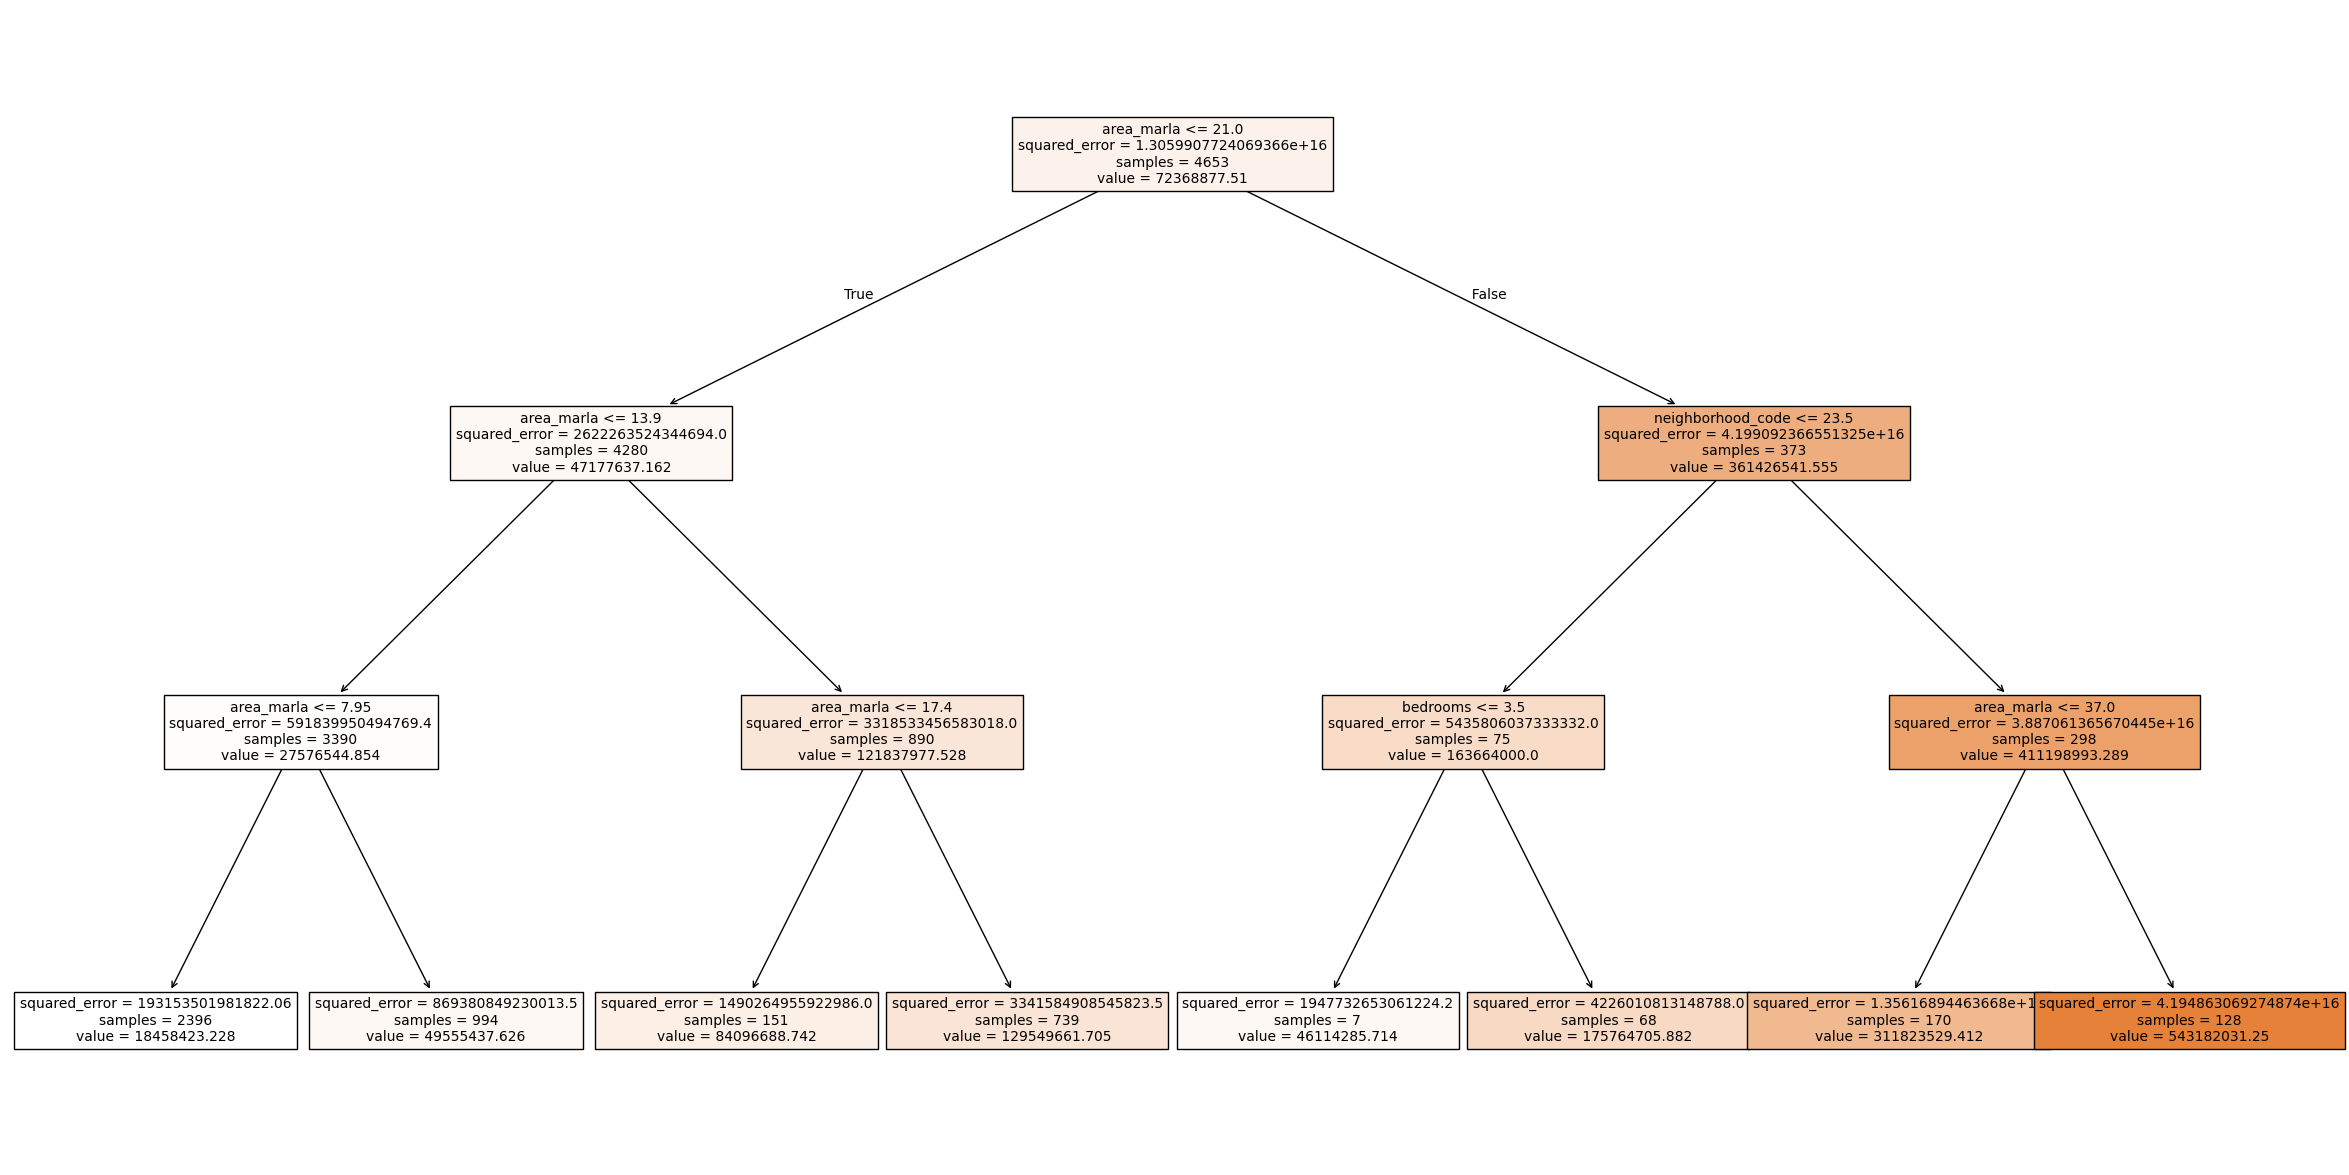

In [4]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Train the Decision Tree
dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(30, 15))
plot_tree(dt_model, feature_names=X.columns, filled=True, max_depth=3, fontsize=10)
plt.show()
